In [1]:
import os 
import gdal 
import rasterio 
from rasterio.merge import merge
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import glob


In [7]:
def merge_tiffs(input_tiffs, output_tiff):
    """
    Merge multiple TIFF files into a single TIFF file.

    Parameters:
    - input_tiffs (list): List of paths to input TIFF files to be merged.
    - output_tiff (str): Path to save the merged TIFF file.

    Returns:
    - None
    """
    # List to store opened raster files
    src_files_to_mosaic = []

    # Open each TIFF file and add it to the list
    for tiff in input_tiffs:
        src = rasterio.open(tiff)
        src_files_to_mosaic.append(src)

    # Merge the opened raster files
    mosaic, out_trans = merge(src_files_to_mosaic)

    # Get metadata from one of the source raster files
    out_meta = src.meta.copy()
    
    # Update metadata with the new dimensions and transform
    out_meta.update({"driver": "GTiff",
                     "height": mosaic.shape[1],
                     "width": mosaic.shape[2],
                     "transform": out_trans})

    # Write the merged raster to disk
    with rasterio.open(output_tiff, "w", **out_meta) as dest:
        dest.write(mosaic)

# Example usage:
# Define the directory path containing TIFF files
directory_path = r'D:\Python\Tiff_files'

# Get a list of all TIFF files in the specified directory
input_tiffs = glob.glob(os.path.join(directory_path, '*.tif'))

# Path to save the merged TIFF file
output_tiff = os.path.join(directory_path, 'merged_output.tif')

# Merge the TIFF files
merge_tiffs(input_tiffs, output_tiff)
print(f'Merged TIFF saved as {output_tiff}')


Merged TIFF saved as D:\Python\Tiff_files\merged_output.tif


C:\Users\Omar.Seleem\AppData\Local\Temp\ipykernel_12680\1675465546.py:33: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  lon, lat = np.meshgrid(x, y) * (~src.transform)


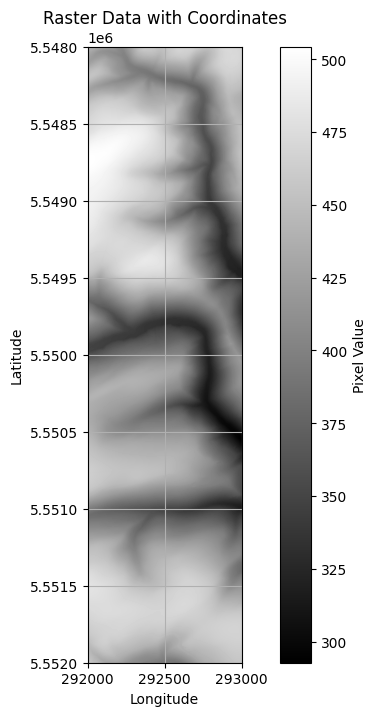

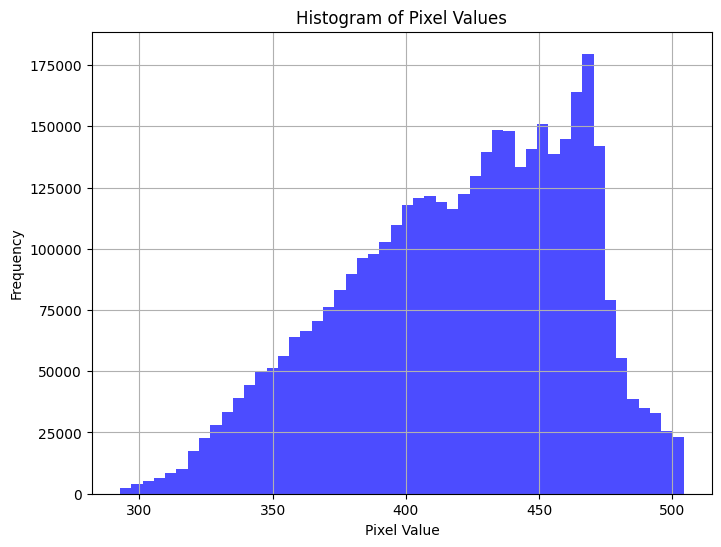

No Data Value: None
Projection: LOCAL_CS["ETRS89 / UTM zone 32N",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Transformation:
| 1.00, 0.00, 291999.50|
| 0.00,-1.00, 5552000.50|
| 0.00, 0.00, 1.00|


In [3]:
def plot_raster_data_with_coordinates(raster_file):
    """
    Read a TIFF file using rasterio, display raster data with coordinates (latitude and longitude),
    plot a histogram of pixel values, and print metadata.

    Parameters:
    - raster_file (str): Path to the TIFF file.

    Returns:
    - None
    """
    # Open the raster file
    with rasterio.open(raster_file) as src:
        # Read raster data
        raster_data = src.read(1, masked=True)  # Read the first band (index 1)

        # Get metadata
        nodata_value = src.nodata
        projection = src.crs
        transform = src.transform

        # Get coordinate information
        width = src.width
        height = src.height
        xmin, ymin = src.transform * (0, 0)
        xmax, ymax = src.transform * (width, height)

        # Generate X and Y coordinates
        x = np.linspace(xmin, xmax, width)
        y = np.linspace(ymin, ymax, height)

        # Transform X and Y coordinates to longitude and latitude
        lon, lat = np.meshgrid(x, y) * (~src.transform)

    # Plot the raster data with coordinates
    plt.figure(figsize=(10, 8))
    plt.imshow(raster_data, extent=[xmin, xmax, ymin, ymax], cmap='gray')
    plt.title('Raster Data with Coordinates')
    plt.colorbar(label='Pixel Value')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.show()

    # Plot histogram
    plt.figure(figsize=(8, 6))
    plt.hist(raster_data.flatten(), bins=50, color='b', alpha=0.7)
    plt.title('Histogram of Pixel Values')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # Print metadata
    print(f"No Data Value: {nodata_value}")
    print(f"Projection: {projection}")
    print(f"Transformation:\n{transform}")


# Example usage:
tif_file = r"D:\Python\Tiff_files\merged_output.tif"
plot_raster_data_with_coordinates(tif_file)



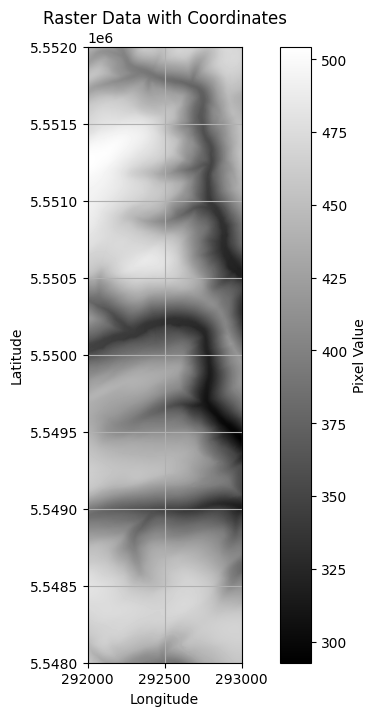

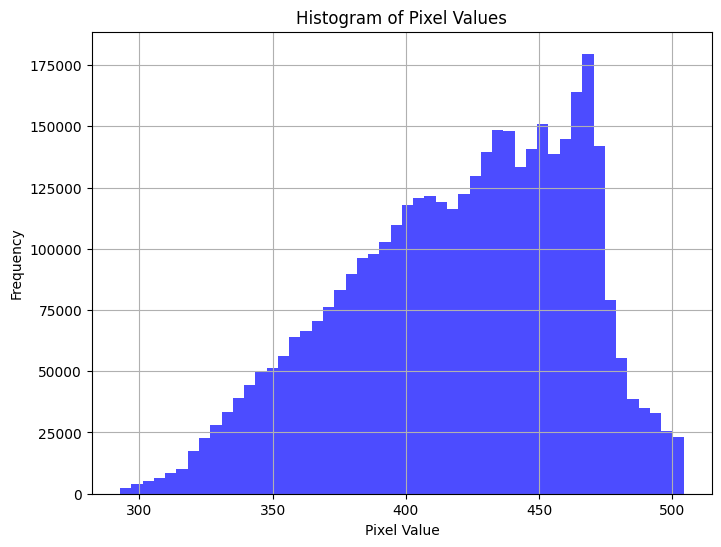

No Data Value: None
Projection: LOCAL_CS["ETRS89 / UTM zone 32N",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Transformation: (291999.5, 1.0, 0.0, 5552000.5, 0.0, -1.0)


In [4]:
def plot_raster_data_with_coordinates_gdal(raster_file):
    # Open the raster file
    dataset = gdal.Open(raster_file, gdal.GA_ReadOnly)

    # Read raster data
    raster_data = dataset.GetRasterBand(1).ReadAsArray()

    # Get raster geotransformation info
    geotransform = dataset.GetGeoTransform()

    # Calculate image extent
    cols = dataset.RasterXSize
    rows = dataset.RasterYSize
    xmin = geotransform[0]
    ymax = geotransform[3]
    xmax = geotransform[0] + geotransform[1] * cols
    ymin = geotransform[3] + geotransform[5] * rows

    # Generate X and Y coordinates
    x = np.linspace(xmin, xmax, cols)
    y = np.linspace(ymin, ymax, rows)

    # Plot the raster data with coordinates
    plt.figure(figsize=(10, 8))
    plt.imshow(raster_data, extent=[xmin, xmax, ymin, ymax], cmap='gray')
    plt.title('Raster Data with Coordinates')
    plt.colorbar(label='Pixel Value')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.show()

    # Plot histogram
    plt.figure(figsize=(8, 6))
    plt.hist(raster_data.flatten(), bins=50, color='b', alpha=0.7)
    plt.title('Histogram of Pixel Values')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # Print metadata
    print("No Data Value:", dataset.GetRasterBand(1).GetNoDataValue())
    print("Projection:", dataset.GetProjection())
    print("Transformation:", geotransform)

    # Close the dataset
    dataset = None
    
# Example usage:
tif_file = r"D:\Python\Tiff_files\merged_output.tif"
plot_raster_data_with_coordinates_gdal(tif_file)